# Hyperparameters

In [1]:
NUM_TREES_PER_CLASS = 5

# Preliminaries

In [2]:
%cd /Users/saketramdurbha/repos/cawl
%pwd

/Users/saketramdurbha/repos/cawl


'/Users/saketramdurbha/repos/cawl'

In [56]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [6]:
from cawl.data.trajectory_regression_dataset import AISTrajectoryRegressionDataset
from cawl.data.gp_kernel_dataset import GPKernelShipClassificationDataset, extract_data
from cawl.models.gp.multioutput_rbf_linear_gp import load_or_train_models
from cawl.models.tree.per_class_decision_tree_model import PerClassDecisionTreeModel
from cawl.models.ensemble import EnsembleModel

from cawl.models.wl.wl import MLP, train, eval_model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Load data

In [8]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:00<00:00, 3944.91it/s]


===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59


Number of vessel groups: 9


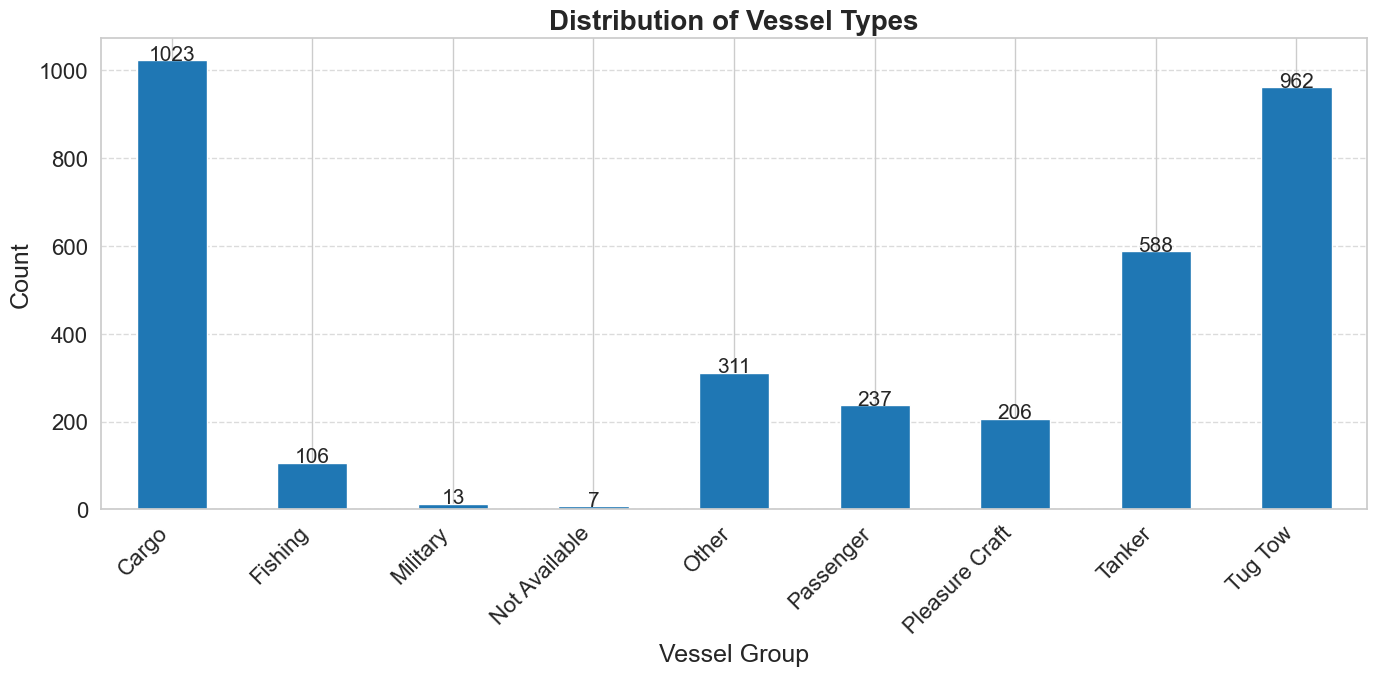

In [9]:
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

In [10]:
reload_existing_models = True
models, likelihoods, losses = load_or_train_models(date_range, gp_regression_dataset, device, reload_existing_models)
print(f"Successfully loaded/trained {len(models)} models for {len(gp_regression_dataset)} trajectories")

Found existing model bundle for date range 2024-01-01 with 3453 trajectories
Loading models from models/rbf_and_linear_kernel_classification_bundle_2024-01-01_n3453.pt instead of retraining...


Loading models: 100%|██████████| 3453/3453 [00:42<00:00, 81.20it/s] 


Successfully loaded 3453 models
Successfully loaded/trained 3453 models for 3453 trajectories


In [11]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45829373598098755, -0.40521514415740967, -0.5071281790733337, -0.37111741304397583, -0.5067406296730042, -0.5076672434806824]
Parameter name: likelihood.raw_noise                       value = [-0.49265846610069275]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.09970027953386307
Parameter name: mean_module.base_means.1.raw_constant      value = -0.08868623524904251
Parameter name: mean_module.base_means.2.raw_constant      value = 0.00029586770688183606
Parameter name: mean_module.base_means.3.raw_constant      value = 0.00010291425860486925
Parameter name: mean_module.base_means.4.raw_constant      value = 0.00023743335623294115
Parameter name: mean_module.base_means.5.raw_constant      value = -0.0020240405574440956
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.7152479887008667], [0.04727381467819214], [0.008950814604759216], [0.16344818472862244], [-0.0059141409583

In [12]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()
print(unique_group_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [13]:
tree_train_dataset, train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.20, 0.40, 0.10, 0.30])
print(len(tree_train_dataset), len(train_dataset), len(validation_dataset), len(test_dataset))

691 1382 345 1035


In [14]:
X_tree_train, y_tree_train, mmsis_tree_train = extract_data(tree_train_dataset)
X_train, y_train, mmsis_train = extract_data(train_dataset)
X_validation, y_validation, mmsis_validation = extract_data(validation_dataset)
X_test, y_test, mmsis_test = extract_data(test_dataset)

# Train the small decision trees model

In [15]:
pcdt_model = PerClassDecisionTreeModel(tree_train_dataset, max_depth=5, feature_fraction=0.75, n_trees_per_class=NUM_TREES_PER_CLASS, confidence_threshold=0.75)
pcdt_model.train_all_trees()

Dataset loaded: 691 samples, 56 features, 9 classes
Training 5 trees per class = 45 total trees
Confidence threshold: 0.75
Training 5 trees for each of 9 classes...
Training set size: 691
Feature fraction per tree: 0.75
Max tree depth: 5


Training trees per class: 100%|██████████| 9/9 [00:00<00:00, 30.67it/s]

Successfully trained 45 trees (5 per class)


## Majority vote of small decision trees performance on test set

In [16]:
pcdt_model.evaluate_ensemble(X_test, y_test, method="majority")

{'accuracy': 0.5024437927663734,
 'coverage': np.float64(0.9884057971014493),
 'predictions': array([6, 0, 7, ..., 0, 0, 8], shape=(1035,)),
 'true_labels': array([6, 0, 8, ..., 0, 7, 4], shape=(1035,)),
 'method': 'majority',
 'n_abstained': np.int64(12),
 'n_predicted': np.int64(1023)}

# Train the learning from weak labelers model

In [17]:
l_train = pcdt_model.predict_ensemble(X_train, method=None)
l_train.shape

(1382, 45)

In [18]:
tree_accuracies = pcdt_model.calculate_individual_tree_accuracies(X_validation, y_validation)
tree_errors = []
accs = []
coverages = []
precisions = []
for class_id in pcdt_model.classes:
    tree_errors.extend( [1 - tree_result["accuracy"] for tree_result in tree_accuracies[class_id]])
    accs.extend( [tree_result["accuracy"] for tree_result in tree_accuracies[class_id]])
    coverages.extend( [tree_result["coverage"] for tree_result in tree_accuracies[class_id]])
    precisions.extend( [tree_result["precision"] for tree_result in tree_accuracies[class_id]])
tree_errors = torch.tensor(tree_errors)
max(coverages)

coverages = np.array(coverages)
precisions = np.array(precisions)
precisions


array([0.58181818, 0.425     , 0.43243243, 0.41176471, 0.58      ,
       0.3125    , 0.25      , 0.22222222, 0.375     , 0.27272727,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2       , 0.        , 0.23076923, 0.11111111, 0.28125   ,
       0.29166667, 0.25806452, 0.41176471, 0.20588235, 0.57142857,
       0.44444444, 0.625     , 0.5       , 0.42857143, 0.75      ,
       0.26923077, 0.34375   , 0.3       , 0.28125   , 0.375     ,
       0.50877193, 0.48351648, 0.4017094 , 0.50526316, 0.3627451 ])

In [19]:
coverages[precisions > 0.50]

array([0.77971014, 0.67246377, 1.        , 1.        , 1.        ,
       0.96231884, 0.90144928])

In [20]:
precisions[precisions > 0.50]

array([0.58181818, 0.58      , 0.57142857, 0.625     , 0.75      ,
       0.50877193, 0.50526316])

In [21]:
masked_l_train = l_train[:, precisions > 0.50]
masked_l_train.shape

(1382, 7)

In [22]:
# eta: is the upper bound on the accuracy of each weak labeler
# In general, we assume that it is given. However, we can tune it with the validation set. e.g. eta_list = [0.01, 0.05, 0.1, 0.15, 0.2]

# eta = torch.ones((45, 1)) * 0.25  # Example eta values

eta = torch.tensor(1 - np.array(precisions[precisions > 0.50]))
# eta = torch.tensor(1 - np.array(precisions))
# eta = tree_errors.detach()

input_dim = X_train.shape[1]
num_classes = len(unique_group_ids)

model = MLP(input_dim, num_classes=num_classes, dropout=0.3)
model = model.to(device)

In [23]:
# Pre-train MLP with majority vote labels
print("Pre-training MLP with majority vote labels...")

# Get majority vote predictions from the tree model
majority_vote_predictions = pcdt_model.predict_ensemble(X_train, method='majority')
nonabstain_mask = majority_vote_predictions != -1

pretrain_optimizer = torch.optim.AdamW(model.parameters())
pretrain_criterion = nn.CrossEntropyLoss()

model.train()
for epoch in tqdm(range(1000)):
    pretrain_optimizer.zero_grad()

    # Forward pass
    outputs = model(torch.tensor(X_train[nonabstain_mask, :], dtype=torch.float32))
    loss = pretrain_criterion(outputs, torch.tensor(majority_vote_predictions[nonabstain_mask]))
    acc = (outputs.argmax(dim=1) == torch.tensor(majority_vote_predictions[nonabstain_mask])).float().mean()

    # Backward pass
    loss.backward()
    pretrain_optimizer.step()

print("Pre-training completed!")
print("Final accuracy: ", acc)
print("Final loss: ", loss)


Pre-training MLP with majority vote labels...


100%|██████████| 1000/1000 [00:07<00:00, 127.01it/s]

Pre-training completed!
Final accuracy:  tensor(0.5465)
Final loss:  tensor(1.1660, grad_fn=<NllLossBackward0>)


In [24]:
# Train the model using the weak labels, and if validation set is provided, use it for early stopping
NUM_EPOCHS = 10_000
# optimizer = torch.optim.AdamW(
#     model.parameters(), lr=3e-4, weight_decay=1e-4,
# )
optimizer = torch.optim.AdamW(model.parameters())
model, best_val_loss = train(model, torch.tensor(X_train), torch.tensor(masked_l_train), eta, optimizer, NUM_EPOCHS, torch.tensor(X_validation), torch.tensor(y_validation))

# If the validation set is not provided, output the latest model
# model, _ = train(model, X_train, l_train, eta, configs)

Epoch 1/10000, Loss: 1.1427, Constraints Violation: 0.0550, Validation Accuracy: 40.8696, Validation Loss: 1.8662
Epoch 2/10000, Loss: 1.1237, Constraints Violation: 0.0695, Validation Accuracy: 42.3188, Validation Loss: 1.8314
Epoch 3/10000, Loss: 1.1071, Constraints Violation: 0.0449, Validation Accuracy: 41.4493, Validation Loss: 1.8786
Epoch 4/10000, Loss: 1.0826, Constraints Violation: 0.0365, Validation Accuracy: 40.2899, Validation Loss: 1.9850
Epoch 5/10000, Loss: 1.0557, Constraints Violation: 0.0318, Validation Accuracy: 39.1304, Validation Loss: 2.0933
Epoch 6/10000, Loss: 1.0074, Constraints Violation: 0.0285, Validation Accuracy: 38.5507, Validation Loss: 2.2097
Epoch 7/10000, Loss: 0.9885, Constraints Violation: 0.0253, Validation Accuracy: 38.8406, Validation Loss: 2.3348
Epoch 8/10000, Loss: 0.9608, Constraints Violation: 0.0228, Validation Accuracy: 38.8406, Validation Loss: 2.4587
Epoch 9/10000, Loss: 0.9217, Constraints Violation: 0.0233, Validation Accuracy: 38.8406

In [25]:
test_acc, test_loss = eval_model(model, torch.tensor(X_test), torch.tensor(y_test))
print(f'The accuracy of the model on the test set is: {test_acc:.4f}')
print(test_loss)

The accuracy of the model on the test set is: 39.8068
1.7443033456802368


## Ensemble model

In [35]:
ensemble_model = EnsembleModel(pcdt_model, model, device=device)
ensemble_model.evaluate(X_test, y_test)

Hybrid ensemble initialized with 9 classes
Tree weight: 0.5, NN weight: 0.5


{'accuracy': 0.49178743961352656,
 'per_class_accuracy': {np.int64(0): 0.5106382978723404,
  np.int64(1): 0.1875,
  np.int64(2): 0.0,
  np.int64(3): 0.0,
  np.int64(4): 0.10256410256410256,
  np.int64(5): 0.25,
  np.int64(6): 0.6333333333333333,
  np.int64(7): 0.21666666666666667,
  np.int64(8): 0.818815331010453},
 'predictions': array([6, 0, 8, ..., 0, 0, 8], shape=(1035,)),
 'probabilities': array([[6.94345236e-02, 4.78750421e-03, 5.21854381e-04, ...,
         6.22531700e-01, 1.42932693e-02, 1.20940354e-01],
        [6.14306617e-01, 2.86018301e-04, 2.11619845e-05, ...,
         3.19441351e-05, 2.03769428e-01, 8.18048324e-03],
        [1.85926616e-01, 4.60550515e-03, 5.34217397e-04, ...,
         1.30992299e-02, 3.29964593e-01, 3.61754708e-01],
        ...,
        [7.26945430e-01, 4.12227962e-07, 6.86157042e-09, ...,
         2.23553940e-08, 2.59636954e-06, 2.72825209e-01],
        [3.92612904e-01, 1.49135443e-03, 1.65236634e-04, ...,
         1.81857427e-03, 3.32996204e-01, 2.21574

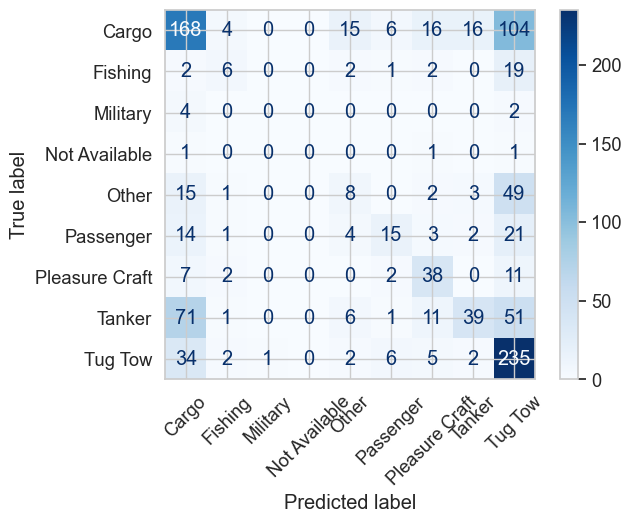

In [53]:
# generate confusion matrix
# y_pred = ensemble_model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

# # plot confusion matrix
# plt.figure(figsize=(10, 10))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

# generate confusion matrix
y_pred = ensemble_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

class_names = [gp_regression_dataset.vessel_group_id_to_group[group_id] for group_id in sorted(unique_group_ids)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [59]:
# classification report
print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

         Cargo       0.53      0.51      0.52       329
       Fishing       0.35      0.19      0.24        32
      Military       0.00      0.00      0.00         6
 Not Available       0.00      0.00      0.00         3
         Other       0.22      0.10      0.14        78
     Passenger       0.48      0.25      0.33        60
Pleasure Craft       0.49      0.63      0.55        60
        Tanker       0.63      0.22      0.32       180
       Tug Tow       0.48      0.82      0.60       287

      accuracy                           0.49      1035
     macro avg       0.35      0.30      0.30      1035
  weighted avg       0.49      0.49      0.46      1035



/Users/saketramdurbha/repos/cawl/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saketramdurbha/repos/cawl/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saketramdurbha/repos/cawl/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

In [54]:
individual_tree_accuracies = pcdt_model.calculate_individual_tree_accuracies(X_test, y_test)

index = 0
print("class", "precision", "accuracy", "coverage", sep="\t\t\t\t")
for class_id in pcdt_model.classes:
    for tree_idx in range(len(pcdt_model.trees_per_class[class_id])):
        precision = precisions[index]
        index += 1
        if precision <= 0.50:
            continue

        print(class_id, individual_tree_accuracies[class_id][tree_idx]["precision"], individual_tree_accuracies[class_id][tree_idx]["accuracy"], individual_tree_accuracies[class_id][tree_idx]["coverage"], sep="\t\t\t\t")


class				precision				accuracy				coverage
0				0.45539906103286387				0.6820448877805486				0.77487922705314
0				0.5157232704402516				0.7114803625377644				0.6396135265700483
5				0.45				0.9381642512077295				1.0
6				0.4657534246575342				0.9371980676328503				1.0
6				0.54				0.9458937198067633				1.0
8				0.5595567867036011				0.7560483870967742				0.9584541062801932
8				0.5362318840579711				0.7478902953586498				0.9159420289855073
